# Visual data exploration: The The Metropolitan Museum of Art NYC
This notebook provides a visual exploration of The Metropolitan Museum of Art's Open Access Collection. We will examine the acquisition timeline, departmental distribution, artist demographics, and geographical origins of the artworks.

## Imports, Data Loading and a First Look

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV file into a DataFrame
csv_file_path = 'MetObjects.csv'
df = pd.read_csv(csv_file_path, low_memory=False)

# Display the first few rows and the info to understand the structure
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Object Number            484956 non-null  object 
 1   Is Highlight             484956 non-null  bool   
 2   Is Timeline Work         484956 non-null  bool   
 3   Is Public Domain         484956 non-null  bool   
 4   Object ID                484956 non-null  int64  
 5   Gallery Number           49541 non-null   object 
 6   Department               484956 non-null  object 
 7   AccessionYear            481094 non-null  object 
 8   Object Name              482690 non-null  object 
 9   Title                    456153 non-null  object 
 10  Culture                  208190 non-null  object 
 11  Period                   91143 non-null   object 
 12  Dynasty                  23201 non-null   object 
 13  Reign                    11236 non-null   object 
 14  Port

The Datafile consists of 484,956 rows (entries) and 54 columns.
47 columns contain textual data (object), the others contain numeric data or boolean values. 

## The Art of Acquisition: An Exploration through Time and Departments

### Heatmap of the Accession of Artworks across Departments

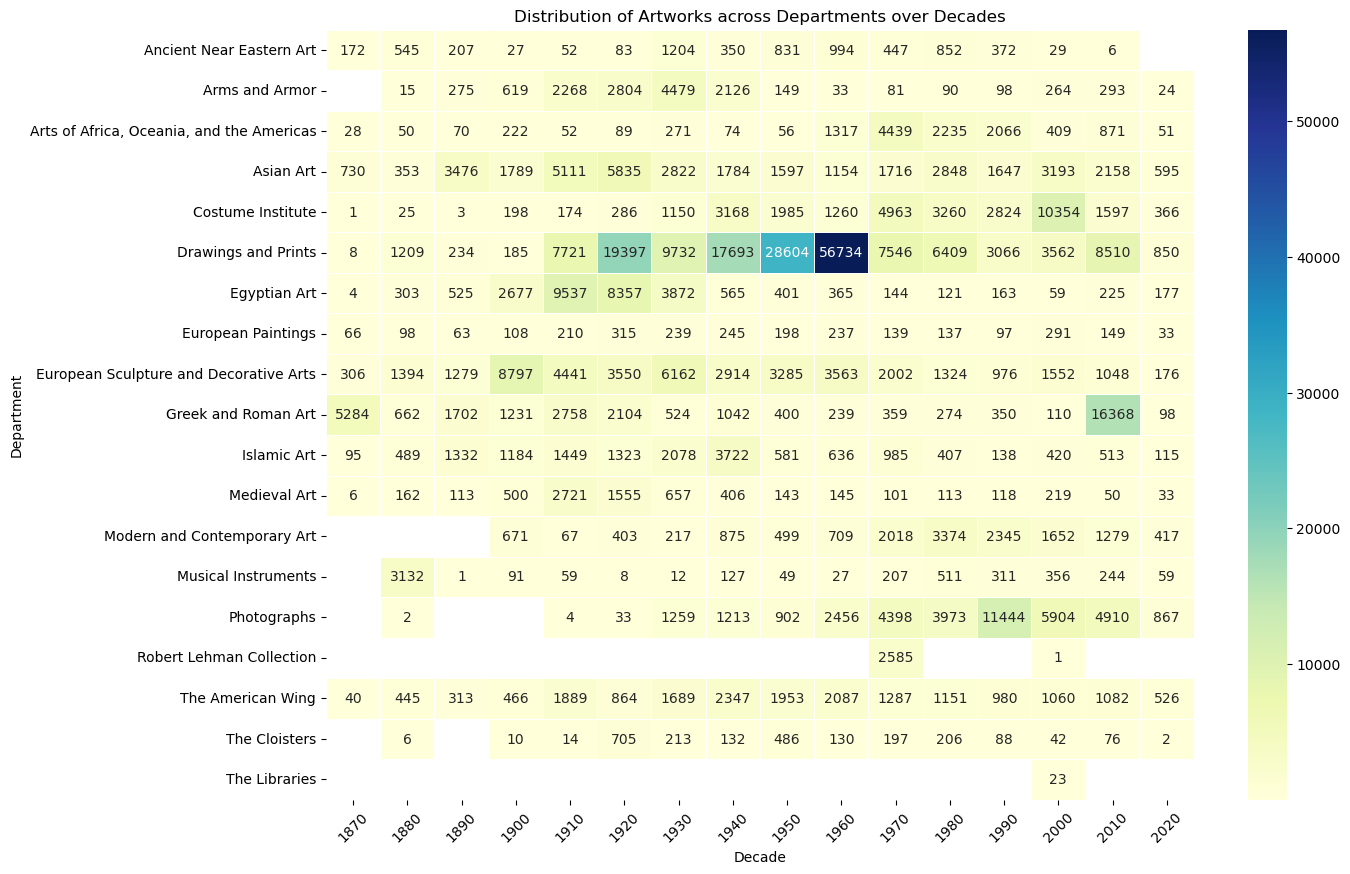

In [89]:
# Convert AccessionYear to numeric (if necessary)
df['AccessionYear'] = pd.to_numeric(df['AccessionYear'], errors='coerce').astype('Int64')

# Round AccessionYear to nearest decade and handle NaN values
df['Decade'] = (df['AccessionYear'] // 10) * 10

# Create pivot table for heatmap
heatmap_data = df.pivot_table(index='Department', columns='Decade', values='Object ID', aggfunc='count')

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)

# Adjust x-axis ticks to show decades as integers
plt.xticks(rotation=45)
plt.title('Distribution of Artworks across Departments over Decades')
plt.xlabel('Decade')
plt.ylabel('Department')
plt.show()

### Bar Chart Distribution of Artworks over all Departments

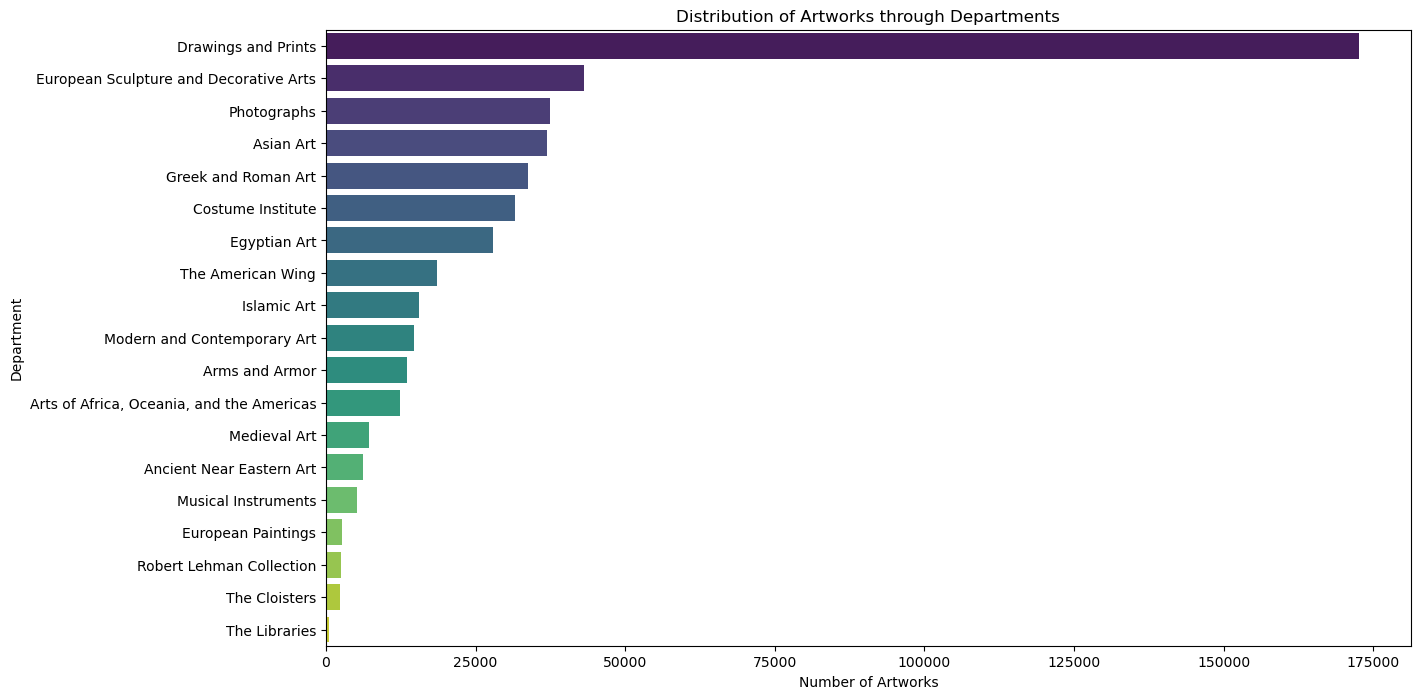

In [92]:
# Group by 'Department' and count the number of artworks
department_counts = df['Department'].value_counts()

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x=department_counts.values, y=department_counts.index, palette='viridis')
plt.title('Distribution of Artworks through Departments')
plt.xlabel('Number of Artworks')
plt.ylabel('Department')
plt.show()

The Drawings and Prints Collection is by far the largest. It is grouped together with the following departments, which are not labelled geographically:

- Photographs
- Costume Institute
- Modern and Contemporary Art
- Arms and Armor
- Musical Instruments
- Robert Lehmann Collection, which appears to be a private collection section
- The Cloisters
- The Libraries

Because of the different categorization of the departments, it is difficult to compare them, e.g. in terms of the geographical distribution of the works of art. For example, the largest department, Drawings and Prints, can include a wide range of nationalities. We will therefore look at artists and works of art in the following steps.

## Beyond the Brush: Get to Know the Artists

### Charts of Gender Representation

#### Preprocessing and Data Cleaning

In [64]:
def clean_gender_value(gender):
    if pd.isnull(gender):
        return 'Unknown'  # Handle NaN values as 'Unknown' or as needed
    
    # Convert to lowercase and strip whitespace
    gender = str(gender).lower().strip()  
    
    # Truncate unwanted patterns like 'i'
    gender = gender.replace('i', '')  
    
    # Check for desired gender categories
    if 'female' in gender and '|' in gender:
        return 'Female'
    elif 'male' in gender:
        return 'Male'
    else:
        return 'Unknown'  # Handle any other cases as 'Unknown' or specific cleaning as needed

# Create a new DataFrame df_gender with cleaned 'Artist Gender' column
df_gender = df.copy()  # Make a copy of original DataFrame

# Apply cleaning function to 'Artist Gender' column
df_gender['Artist Gender'] = df_gender['Artist Gender'].apply(clean_gender_value)

# Display unique values to verify
print(df_gender['Artist Gender'].unique())

['Unknown' 'Female' 'Male']


#### Visualisation

Number of unique artists: 58035


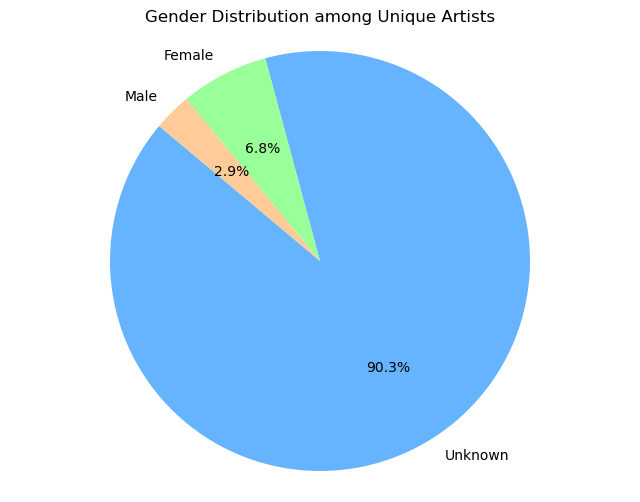

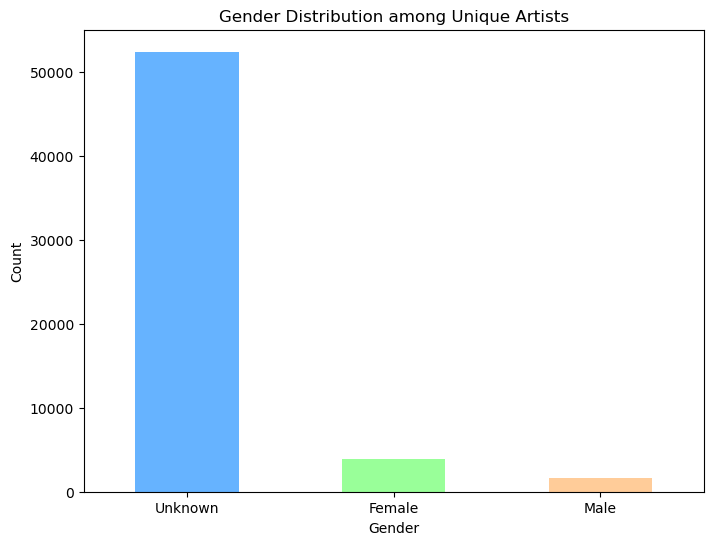

In [69]:
# Split 'Artist Display Name' by '|', expand into separate rows
artists_split = df_gender['Artist Display Name'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).rename('Artist Display Name')

# Create a new DataFrame with split artists
df_split_artists = df_gender.drop('Artist Display Name', axis=1).join(artists_split)

# Group by artist names and keep the first gender value encountered
unique_artists = df_split_artists.drop_duplicates(subset=['Artist Display Name'], keep='first')

# Count values in 'Artist Gender' column after grouping
gender_counts = unique_artists['Artist Gender'].value_counts()

# Count number of unique artists
unique_artist_count = unique_artists['Artist Display Name'].nunique()
print("Number of unique artists:", unique_artist_count)

# Plotting pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Gender Distribution among Unique Artists')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Plotting bar chart
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Gender Distribution among Unique Artists')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Unfortunately, in 90% of the objects there is no information on the gender of the artist.

### Bar Chart of Nationality & Highlight Status

#### Preprocessing & Data Cleaning

In [74]:
# Function to clean nationality values with case normalization and splitting
def clean_nationality(nationality):
    if pd.isna(nationality) or nationality == '':
        return 'Unknown'
    cleaned = str(nationality).strip().lower()  # Convert to lowercase and strip whitespace
    # Remove unwanted characters
    cleaned = cleaned.replace("'", "").replace(",", "").replace("I", " ")  # Remove apostrophes, commas, and convert 'I' to space
    # Split by whitespace, strip spaces, remove empty parts, and join with '|'
    cleaned_list = [part.strip() for part in cleaned.split() if part.strip() and 'born' not in part]  # Exclude parts containing 'born'
    cleaned = '|'.join(cleaned_list)
    return cleaned

# Clean 'Artist Nationality' column using .loc (Apply cleaning function)
unique_artists.loc[:, 'Artist Nationality'] = unique_artists['Artist Nationality'].apply(clean_nationality)

# Replace NaNs in 'Artist Nationality' with 'Unknown'
unique_artists.loc[unique_artists['Artist Nationality'].isna(), 'Artist Nationality'] = 'Unknown'

# Expand nationalities into separate rows
expanded_rows = []
for index, row in unique_artists.iterrows():
    nationalities = row['Artist Nationality'].split('|')
    for nationality in nationalities:
        expanded_rows.append({'Artist Nationality': nationality, 'Is Highlight': row['Is Highlight']})

expanded_df = pd.DataFrame(expanded_rows)

#### Visualisation

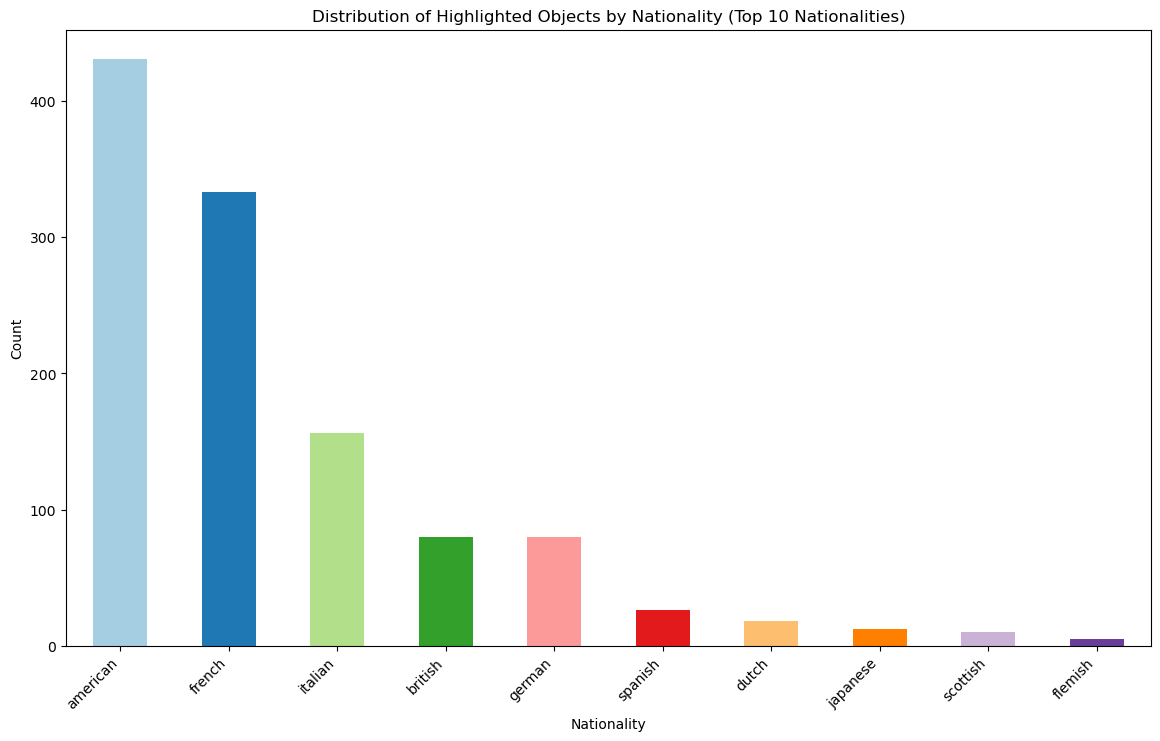

In [79]:
# Filter out 'Unknown' and empty nationalities
filtered_df = expanded_df[(expanded_df['Artist Nationality'] != 'unknown') & (expanded_df['Artist Nationality'] != '')]

# Determine the top 10 nationalities by count
top_nationalities = filtered_df['Artist Nationality'].value_counts().nlargest(10).index

# Filter the DataFrame to only include highlighted rows with the top 10 nationalities
highlighted_df = filtered_df[(filtered_df['Is Highlight'] == True) & (filtered_df['Artist Nationality'].isin(top_nationalities))]

# Count the number of highlighted objects by nationality
count_data = highlighted_df['Artist Nationality'].value_counts().reindex(top_nationalities)

# Sort count_data in descending order by count
count_data = count_data.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(14, 8))
count_data.plot(kind='bar', color=sns.color_palette("Paired", len(count_data)))
plt.title('Distribution of Highlighted Objects by Nationality (Top 10 Nationalities)')
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend().remove()  # Remove legend
plt.show()

The highlighted artworks in the collection are mostly by artists of American or European heritage. It is interesting to note that although the museum has a large collection of East Asian artworks, the number of highlighted artworks by Japanese artists is almost the same as the number of highlighted artworks by Scottish artists.

## Mapping Masterpieces: Geographical Distribution of the Art

### Choropleth World Map

### Filterable Map by Department & Culture

## Conclusion